# Conv Architecture Experiment Results

In [1]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.stats.api as sms

from db import conn

/u3/z3tu/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline

In [3]:
sns.set_style("whitegrid")

In [4]:
cursor = conn.cursor()
experiment_rows = [r for r in cursor.execute("""
    select g.name, args, dev_metric, test_metric from experiments e
    join experiment_groups g on e.group_id=g.gid
    where g.name=?""", ('mpcnn-conv-fix-params-and-seed',))]

In [5]:
len(experiment_rows)

72

In [6]:
experiment_results = {
    'trecqa': [],
    'wikiqa': [],
    'sick': []
}

for row in experiment_rows:
    args = json.loads(row[1])
    dev_metrics = json.loads(row[2])
    test_metrics = json.loads(row[3])
    dataset = args['dataset']
    
    if args['arch'] == 'mpcnn_holistic_only':
        arch = 'holistic-only'
    else:
        arch = 'mpcnn'
    
    res_base = {
        'arch': arch,
        'dataset': dataset,
        'seed': args['seed']
    }
    
    results = []
    
    if dataset in ('trecqa', 'wikiqa'):
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MAP', 'metric_val': dev_metrics['map']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MRR', 'metric_val': dev_metrics['mrr']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MAP', 'metric_val': test_metrics['map']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MRR', 'metric_val': test_metrics['mrr']}})
    elif dataset == 'sick':
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'pearson', 'metric_val': dev_metrics['pearson']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'spearman', 'metric_val': dev_metrics['spearman']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'pearson', 'metric_val': test_metrics['pearson']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'spearman', 'metric_val': test_metrics['spearman']}})
    
    experiment_results[dataset].extend(results)

In [7]:
trecqa = pd.DataFrame(experiment_results['trecqa'])
wikiqa = pd.DataFrame(experiment_results['wikiqa'])
sick = pd.DataFrame(experiment_results['sick'])

In [8]:
trecqa.head(8)

,arch,dataset,metric_name,metric_val,seed,split
0,mpcnn,trecqa,MAP,0.8088,524729,dev
1,mpcnn,trecqa,MRR,0.8582,524729,dev
2,mpcnn,trecqa,MAP,0.7823,524729,test
3,mpcnn,trecqa,MRR,0.8279,524729,test
4,holistic-only,trecqa,MAP,0.7931,524729,dev
5,holistic-only,trecqa,MRR,0.8475,524729,dev
6,holistic-only,trecqa,MAP,0.7961,524729,test
7,holistic-only,trecqa,MRR,0.8468,524729,test


In [9]:
archs = ['mpcnn', 'holistic-only']
def compare_change_to_baseline(df, metric):
    config_ids = df['seed'].unique()
    for arch in archs:
        diffs = []
        for config_id in config_ids:
            baseline = df[(df['seed'] == config_id) & (df['arch'] == 'mpcnn')].iloc[0]['metric_val']
            conf_perf = df[(df['seed'] == config_id) & (df['arch'] == arch)].iloc[0]['metric_val']
            diffs.append(conf_perf - baseline)

        print(f'Architecture: {arch}')
        print(f'Median of {metric} change compared with holistic-only baseline: {np.median(diffs):.4f}')
        print(f'Mean of {metric} change compared with holistic-only baseline: {np.mean(diffs):.4f}')

## TrecQA

In [10]:
trec_map_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'test')]
trec_mrr_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'test')]
trec_map_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'dev')]
trec_mrr_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'dev')]

In [11]:
for arch in trec_map_vs_archs_test['arch'].unique():
    arr = trec_map_vs_archs_test[trec_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

mpcnn: (0.7121, 0.7920)
holistic-only: (0.7752, 0.7859)


In [12]:
for arch in trec_mrr_vs_archs_test['arch'].unique():
    arr = trec_mrr_vs_archs_test[trec_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

mpcnn: (0.7499, 0.8366)
holistic-only: (0.8187, 0.8380)


In [13]:
trec_map_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
holistic-only,0.780550,455105.75
mpcnn,0.752042,455105.75


In [14]:
trec_mrr_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
holistic-only,0.828358,455105.75
mpcnn,0.793242,455105.75


In [15]:
compare_change_to_baseline(trec_map_vs_archs_test, 'MAP')

Architecture: mpcnn
Median of MAP change compared with holistic-only baseline: 0.0000
Mean of MAP change compared with holistic-only baseline: 0.0000
Architecture: holistic-only
Median of MAP change compared with holistic-only baseline: 0.0056
Mean of MAP change compared with holistic-only baseline: 0.0285


In [16]:
compare_change_to_baseline(trec_mrr_vs_archs_test, 'MRR')

Architecture: mpcnn
Median of MRR change compared with holistic-only baseline: 0.0000
Mean of MRR change compared with holistic-only baseline: 0.0000
Architecture: holistic-only
Median of MRR change compared with holistic-only baseline: 0.0102
Mean of MRR change compared with holistic-only baseline: 0.0351


In [17]:
compare_change_to_baseline(trec_map_vs_archs_dev, 'MAP')

Architecture: mpcnn
Median of MAP change compared with holistic-only baseline: 0.0000
Mean of MAP change compared with holistic-only baseline: 0.0000
Architecture: holistic-only
Median of MAP change compared with holistic-only baseline: -0.0010
Mean of MAP change compared with holistic-only baseline: 0.0211


In [18]:
compare_change_to_baseline(trec_mrr_vs_archs_dev, 'MRR')

Architecture: mpcnn
Median of MRR change compared with holistic-only baseline: 0.0000
Mean of MRR change compared with holistic-only baseline: 0.0000
Architecture: holistic-only
Median of MRR change compared with holistic-only baseline: -0.0074
Mean of MRR change compared with holistic-only baseline: 0.0236


(0.75, 0.81)

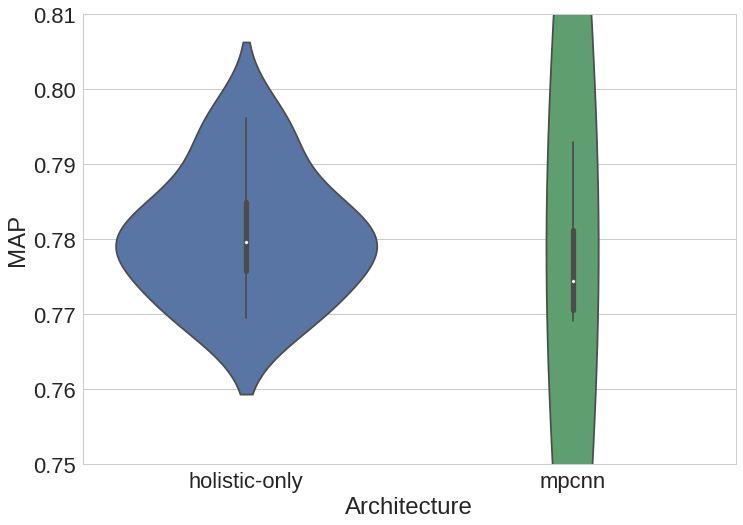

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.violinplot(x='arch', y='metric_val', data=trec_map_vs_archs_test, order=['holistic-only', 'mpcnn'], ax=ax)
plt.xlabel('Architecture', fontsize=24)
plt.ylabel('MAP', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylim(0.75, 0.81)

(0.8, 0.85)

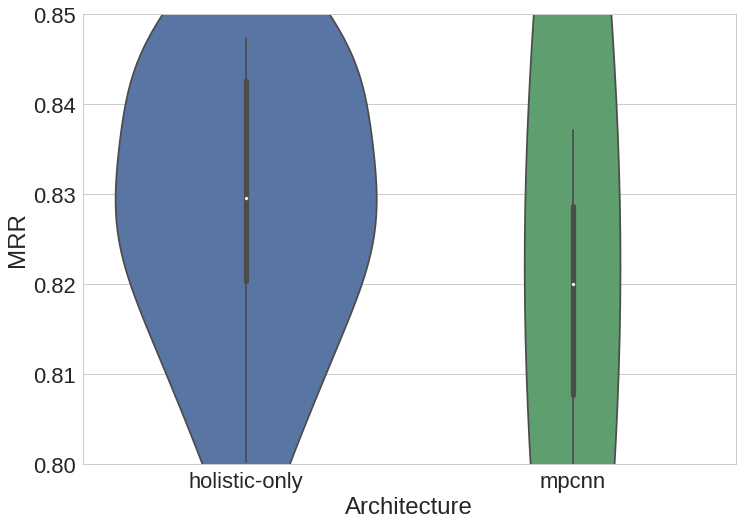

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.violinplot(x='arch', y='metric_val', data=trec_mrr_vs_archs_test, order=['holistic-only', 'mpcnn'], ax=ax)
plt.xlabel('Architecture', fontsize=24)
plt.ylabel('MRR', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylim(0.8, 0.85)

## WikiQA

In [21]:
wikiqa_map_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'test')]
wikiqa_mrr_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'test')]
wikiqa_map_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'dev')]
wikiqa_mrr_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'dev')]

In [22]:
for arch in wikiqa_map_vs_archs_test['arch'].unique():
    arr = wikiqa_map_vs_archs_test[wikiqa_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

mpcnn: (0.5535, 0.7044)
holistic-only: (0.5844, 0.6987)


In [23]:
for arch in wikiqa_mrr_vs_archs_test['arch'].unique():
    arr = wikiqa_mrr_vs_archs_test[wikiqa_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

mpcnn: (0.5611, 0.7180)
holistic-only: (0.5931, 0.7120)


In [24]:
wikiqa_map_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
holistic-only,0.641533,455105.75
mpcnn,0.628908,455105.75


In [25]:
wikiqa_mrr_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
holistic-only,0.652517,455105.75
mpcnn,0.639550,455105.75


In [26]:
compare_change_to_baseline(wikiqa_map_vs_archs_test, 'MAP')

Architecture: mpcnn
Median of MAP change compared with holistic-only baseline: 0.0000
Mean of MAP change compared with holistic-only baseline: 0.0000
Architecture: holistic-only
Median of MAP change compared with holistic-only baseline: 0.0052
Mean of MAP change compared with holistic-only baseline: 0.0126


In [27]:
compare_change_to_baseline(wikiqa_mrr_vs_archs_test, 'MRR')

Architecture: mpcnn
Median of MRR change compared with holistic-only baseline: 0.0000
Mean of MRR change compared with holistic-only baseline: 0.0000
Architecture: holistic-only
Median of MRR change compared with holistic-only baseline: 0.0066
Mean of MRR change compared with holistic-only baseline: 0.0130


In [28]:
compare_change_to_baseline(wikiqa_map_vs_archs_dev, 'MAP')

Architecture: mpcnn
Median of MAP change compared with holistic-only baseline: 0.0000
Mean of MAP change compared with holistic-only baseline: 0.0000
Architecture: holistic-only
Median of MAP change compared with holistic-only baseline: -0.0030
Mean of MAP change compared with holistic-only baseline: 0.0047


In [29]:
compare_change_to_baseline(wikiqa_mrr_vs_archs_dev, 'MRR')

Architecture: mpcnn
Median of MRR change compared with holistic-only baseline: 0.0000
Mean of MRR change compared with holistic-only baseline: 0.0000
Architecture: holistic-only
Median of MRR change compared with holistic-only baseline: -0.0014
Mean of MRR change compared with holistic-only baseline: 0.0043


(0.6, 0.75)

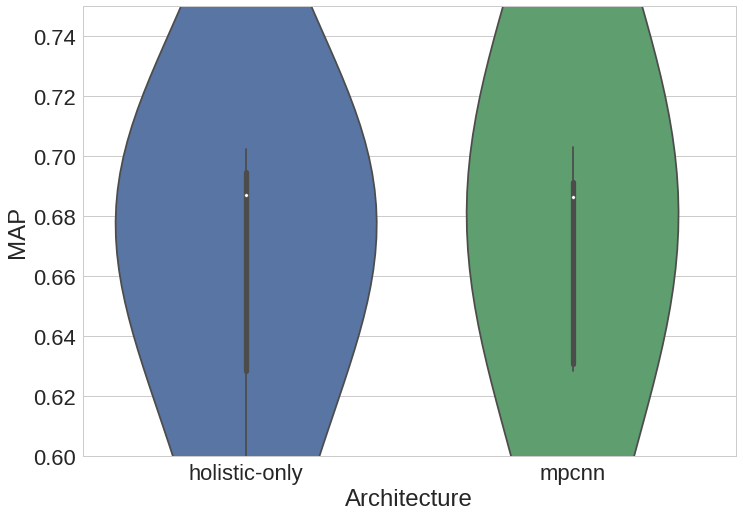

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.violinplot(x='arch', y='metric_val', data=wikiqa_map_vs_archs_test, order=['holistic-only', 'mpcnn'], ax=ax)
plt.xlabel('Architecture', fontsize=24)
plt.ylabel('MAP', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylim(0.6, 0.75)

## SICK

In [31]:
sick_pearson_vs_archs_test = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'test')]
sick_spearman_vs_archs_test = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'test')]
sick_pearson_vs_archs_dev = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'dev')]
sick_spearman_vs_archs_dev = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'dev')]

In [32]:
for arch in sick_pearson_vs_archs_test['arch'].unique():
    arr = sick_pearson_vs_archs_test[sick_pearson_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

mpcnn: (0.8634, 0.8714)
holistic-only: (0.8618, 0.8697)


In [33]:
for arch in sick_spearman_vs_archs_test['arch'].unique():
    arr = sick_spearman_vs_archs_test[sick_spearman_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

mpcnn: (0.7972, 0.8061)
holistic-only: (0.7948, 0.8041)


In [34]:
sick_pearson_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
holistic-only,0.865725,455105.75
mpcnn,0.867405,455105.75


In [35]:
sick_spearman_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
holistic-only,0.799473,455105.75
mpcnn,0.801643,455105.75


In [36]:
compare_change_to_baseline(sick_pearson_vs_archs_test, 'pearson')

Architecture: mpcnn
Median of pearson change compared with holistic-only baseline: 0.0000
Mean of pearson change compared with holistic-only baseline: 0.0000
Architecture: holistic-only
Median of pearson change compared with holistic-only baseline: -0.0013
Mean of pearson change compared with holistic-only baseline: -0.0017


In [37]:
compare_change_to_baseline(sick_spearman_vs_archs_test, 'spearman')

Architecture: mpcnn
Median of spearman change compared with holistic-only baseline: 0.0000
Mean of spearman change compared with holistic-only baseline: 0.0000
Architecture: holistic-only
Median of spearman change compared with holistic-only baseline: -0.0022
Mean of spearman change compared with holistic-only baseline: -0.0022


In [38]:
compare_change_to_baseline(sick_pearson_vs_archs_dev, 'pearson')

Architecture: mpcnn
Median of pearson change compared with holistic-only baseline: 0.0000
Mean of pearson change compared with holistic-only baseline: 0.0000
Architecture: holistic-only
Median of pearson change compared with holistic-only baseline: -0.0018
Mean of pearson change compared with holistic-only baseline: -0.0017


In [39]:
compare_change_to_baseline(sick_spearman_vs_archs_dev, 'spearman')

Architecture: mpcnn
Median of spearman change compared with holistic-only baseline: 0.0000
Mean of spearman change compared with holistic-only baseline: 0.0000
Architecture: holistic-only
Median of spearman change compared with holistic-only baseline: -0.0015
Mean of spearman change compared with holistic-only baseline: -0.0013


(0.86, 0.88)

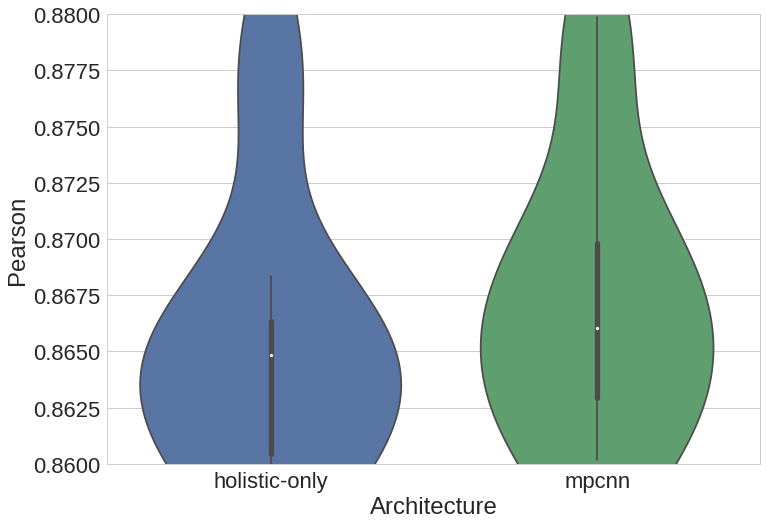

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.violinplot(x='arch', y='metric_val', data=sick_pearson_vs_archs_test, order=['holistic-only', 'mpcnn'], ax=ax)
plt.xlabel('Architecture', fontsize=24)
plt.ylabel('Pearson', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylim(0.86, 0.88)

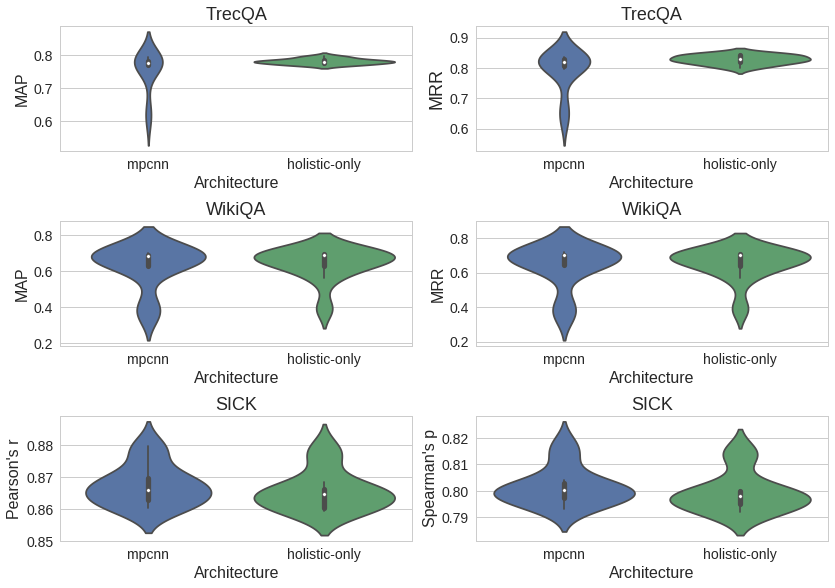

In [41]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
title_size = 18
axis_size = 16
tick_size = 14

ax = plt.subplot(321)
sns.violinplot(x='arch', y='metric_val', data=trec_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MAP', fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('TrecQA', fontsize=title_size)

ax = plt.subplot(322)
sns.violinplot(x='arch', y='metric_val', data=trec_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=18)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('TrecQA', fontsize=title_size)

ax = plt.subplot(323)
sns.violinplot(x='arch', y='metric_val', data=wikiqa_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MAP', fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('WikiQA', fontsize=title_size)

ax = plt.subplot(324)
sns.violinplot(x='arch', y='metric_val', data=wikiqa_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('WikiQA', fontsize=title_size)

ax = plt.subplot(325)
sns.violinplot(x='arch', y='metric_val', data=sick_pearson_vs_archs_test, order=archs, ax=ax)
plt.ylabel("Pearson's r", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('SICK', fontsize=title_size)

ax = plt.subplot(326)
sns.violinplot(x='arch', y='metric_val', data=sick_spearman_vs_archs_test, order=archs, ax=ax)
plt.ylabel("Spearman's p", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('SICK', fontsize=title_size)
plt.tight_layout()
plt.savefig('conv_arch_violin.pdf')